##Import required modules:

In [1]:
import numpy as np
import pandas as pd  
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
!pip install pca
from pca import pca as pca_lib

from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans

# Ignore OMP thread count with k-means
import warnings
warnings.filterwarnings('ignore')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


##Read CSV file into dataframe:

In [2]:
# Load data
arrest_df = pd.read_csv('UsArrests.csv')
arrest_df.head(10)

,City,Murder,Assault,UrbanPop,Rape
0,Alabama,13.2,236,58,21.2
1,Alaska,10.0,263,48,44.5
2,Arizona,8.1,294,80,31.0
3,Arkansas,8.8,190,50,19.5
4,California,9.0,276,91,40.6
5,Colorado,7.9,204,78,38.7
6,Connecticut,3.3,110,77,11.1
7,Delaware,5.9,238,72,15.8
8,Florida,15.4,335,80,31.9
9,Georgia,17.4,211,60,25.8


**Murder** – the number of murder arrests per 100,000 people in a given state

**Assault** – the number of assault arrests per 100,000 people in a given state

**UrbanPop** – a numeric percentage of the urban population per state (i.e. the percentage of the state’s population that lives in cities)

**Rape** – the number of rape arrests per 100,000 people in a given state

In [3]:
print('Number of cases: {} Number of features: {}'.format(arrest_df.shape[0],arrest_df.shape[1]))

Number of cases: 50 Number of features: 5


In [4]:
arrest_df['City'].nunique()

50

##Rename 'City' column to 'State' to aid understanding:

In [5]:
arrest_df.rename(columns = {'City':'State'}, inplace = True)

##Variable types:

In [6]:
# Examine types
arrest_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   State     50 non-null     object 
 1   Murder    50 non-null     float64
 2   Assault   50 non-null     int64  
 3   UrbanPop  50 non-null     int64  
 4   Rape      50 non-null     float64
dtypes: float64(2), int64(2), object(1)
memory usage: 2.1+ KB


We can see that our DataFrame has 5 features. 

The objective of our report, will be to use PCA and hierarchical clustering to represent how each crime attributes itself to each state. We can therefore use state as the response variable with crime and population being the predictor variables.

##Make numerical features float types:

In [7]:
arrest_df['Assault'] = arrest_df['Assault'].astype('float64')
arrest_df['UrbanPop'] = arrest_df['UrbanPop'].astype('float64')
arrest_df.dtypes

State        object
Murder      float64
Assault     float64
UrbanPop    float64
Rape        float64
dtype: object

##Identify missing values:

In [8]:
# Count missing values
missing = arrest_df.isnull().sum()
relevant_missing = pd.DataFrame(missing, columns=["missing"])
relevant_missing

,missing
State,0
Murder,0
Assault,0
UrbanPop,0
Rape,0


There are no missing values.

##Summarise statistical properties:

In [9]:
arrest_df.describe()

,Murder,Assault,UrbanPop,Rape
count,50.00000,50.000000,50.000000,50.000000
mean,7.78800,170.760000,65.540000,21.232000
std,4.35551,83.337661,14.474763,9.366385
min,0.80000,45.000000,32.000000,7.300000
25%,4.07500,109.000000,54.500000,15.075000
50%,7.25000,159.000000,66.000000,20.100000
75%,11.25000,249.000000,77.750000,26.175000
max,17.40000,337.000000,91.000000,46.000000


###Display selected stats in more readable format:

In [51]:
#Statistical properties of the columns
stats = arrest_df.describe()
selected_stats = stats.loc[["mean","std","min","max"]].transpose()
selected_stats

,mean,std,min,max
Murder,7.788,4.355510,0.8,17.4
Assault,170.760,83.337661,45.0,337.0
UrbanPop,65.540,14.474763,32.0,91.0
Rape,21.232,9.366385,7.3,46.0


#Feature Relationships:

##Visualise distribution for each feature:

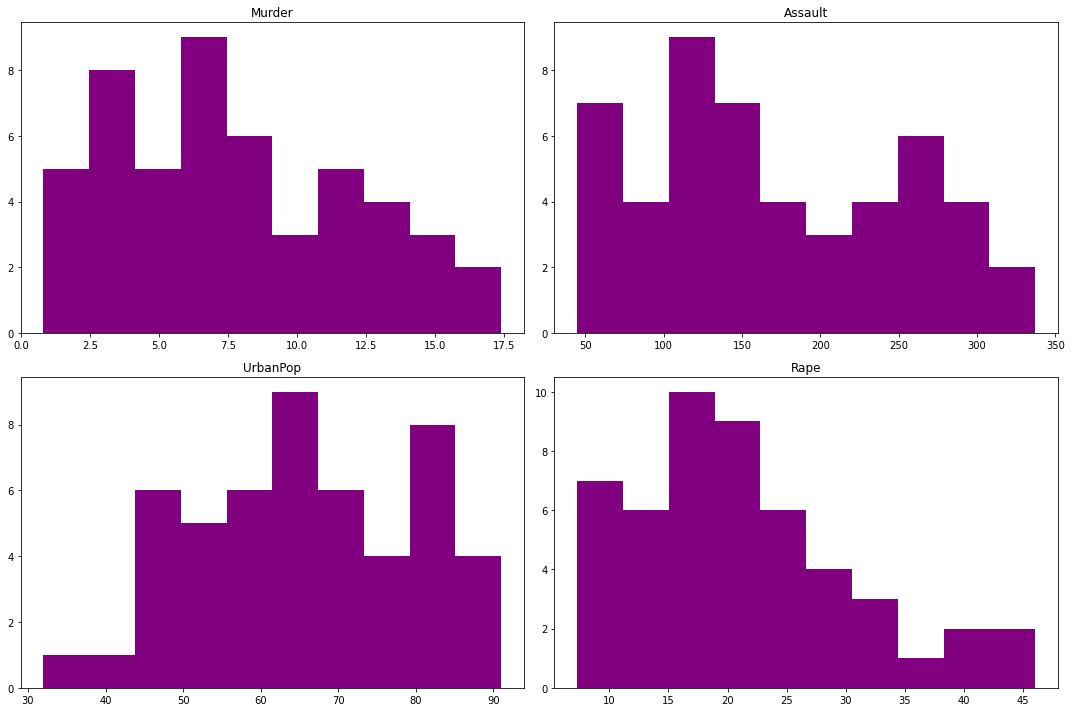

In [52]:
# Plot histograms
histograms = arrest_df.hist(color='purple', grid=False, figsize=(15, 10))
plt.tight_layout()
plt.show()

##Plot Pairplot:

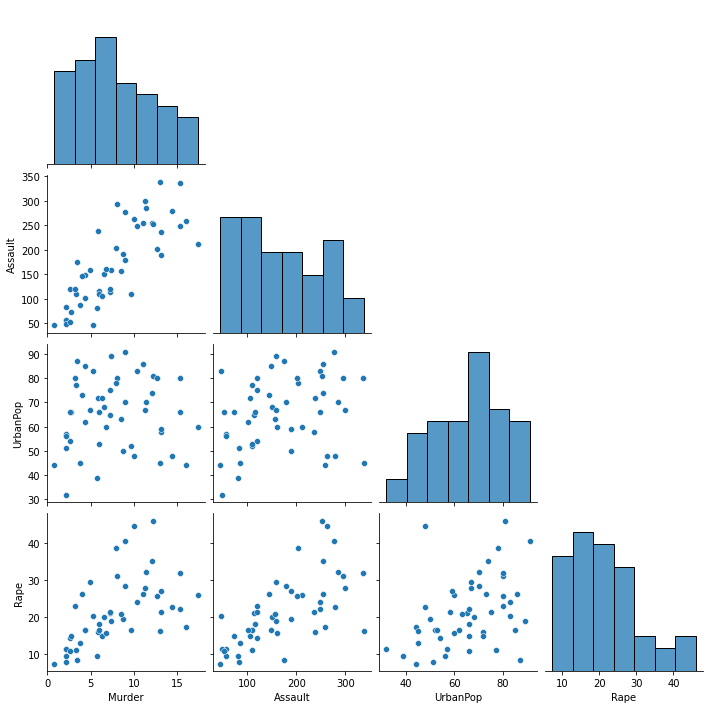

In [12]:
#Plot pairplot
sns.pairplot(arrest_df, corner = True)

The above pair plot shows mostly positive correlations between all crimes. This is to be expected as the more violent a neighbourhood, the more likely it is to have a rise in all crimes.

##Create heatmap to show how variables correlate:

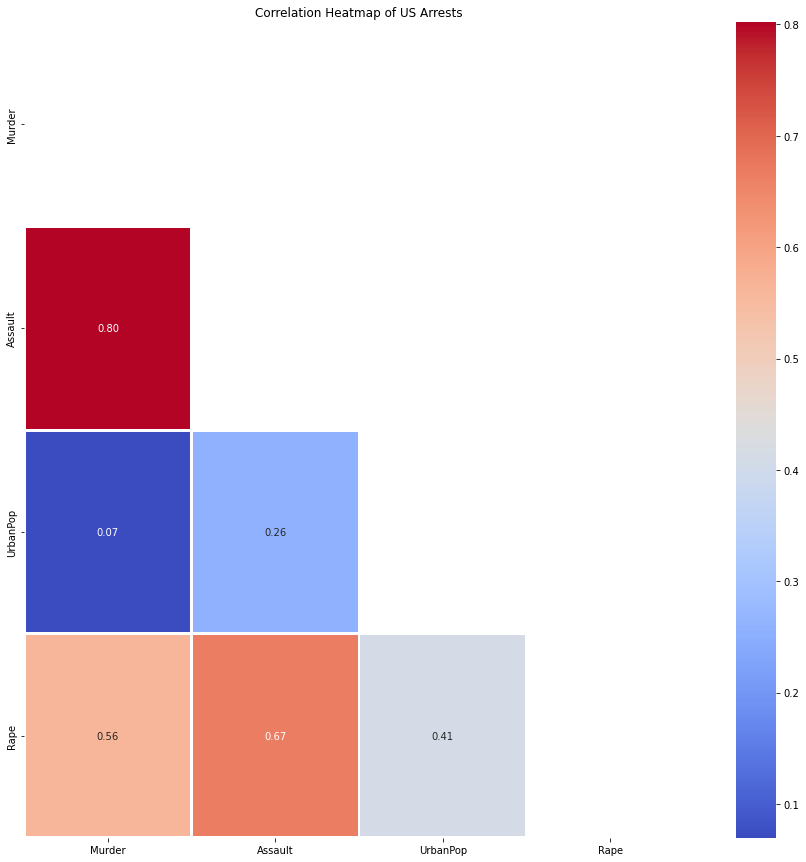

In [13]:
def corr_heatmap(arrest_df):
  # get correlations
  corrs = arrest_df.corr()

  # pick appropriate palette for heatmap#
  colormap = sns.diverging_palette(220, 10, as_cmap=True)

  # Plot figsize
  fig, ax = plt.subplots(figsize=(15, 15))

  # mask mirrored side of heatmap
  dropSelf = np.zeros_like(corrs)
  dropSelf[np.triu_indices_from(dropSelf)] = True

  # fenerate Heat Map, with annotations of the correlation strength and 2-decimal floats
  ax = sns.heatmap(corrs, cmap='coolwarm', annot=True, fmt=".2f", mask=dropSelf, linewidth=2)

  plt.title('Correlation Heatmap of US Arrests')

  plt.show()

corr_heatmap(arrest_df)

Correlation ranges from 0 to 1 in this plot. In the plot, there is a linear correlation between strongly correlated variables: those coloured in dark red. Values closer to zero (dark blue) mean there is no linear trend between the two variables. 

The closer to 1 the correlation is the more positively correlated they are; that is as one increases so does the other and the closer to 1 the stronger this relationship is. These variables will be in red.

A correlation closer to -1 is similar, but instead of both increasing, one variable will decrease as the other increases as they are negatively correlated. There are none of these in this plot. 

From the correlation plot, it is evident that Murder has a strong positive correlation to Assault (0.80) meaning that as the amount of assaults rise, so do the amounts of murders. 

Assault and rape are the next highest positive correlation (0.67).

The final weaker positive correlation is murder to rape (0.56).

These positive correlations are to be expected due to assault showing a neighbourhood is violent and the more violent a neighbourhood, the more crime is likely to take place.

Looking at the variables against UrbanPop, we can see that there is less of a correlation between this and the other variables. UrbanPop is the most strongly correlated to rape (0.41) but this is not a very strong correlation.

The lowest correlation is between UrbanPop and Murder at 0.07 showing there is no real relationship between these two variables.

##Boxplot for feature distribution:

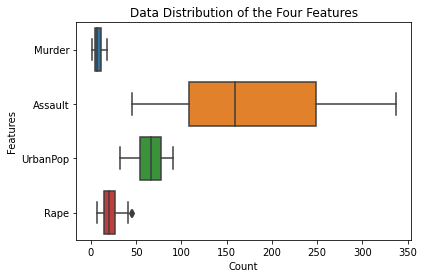

In [14]:
# plot boxplot
sns.boxplot(data = arrest_df, orient = 'h')
plt.ylabel('Features')
plt.xlabel('Count')
plt.title('Data Distribution of the Four Features')
plt.show()

From the boxplot, we can see that the most frequent crime is Assault. This is then followed by rape and finally the least frequent crime is Murder. 

UrbanPop is not really a valid plot on this boxplot due to it being a percentage rather than a count so unable to go above 100. 

#PCA report

##Biplot to represent Components within the DataFrame:

###Fit PCA:

In [15]:
pca = PCA().fit(arrest_df.iloc[:,1:5])

[pca] >Processing dataframe..
[pca] >The PCA reduction is performed on the [4] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Outlier detection using Hotelling T2 test with alpha=[0.05] and n_components=[2]
[pca] >Outlier detection using SPE/DmodX with n_std=[2]
[pca] >Plot PC1 vs PC2 with loadings.
[colourmap]> Warning: Colormap [Set1] can not create [50] unique colors! Available unique colors: [9].
[colourmap]> Warning: Colormap [Set1] can not create [50] unique colors! Available unique colors: [9].


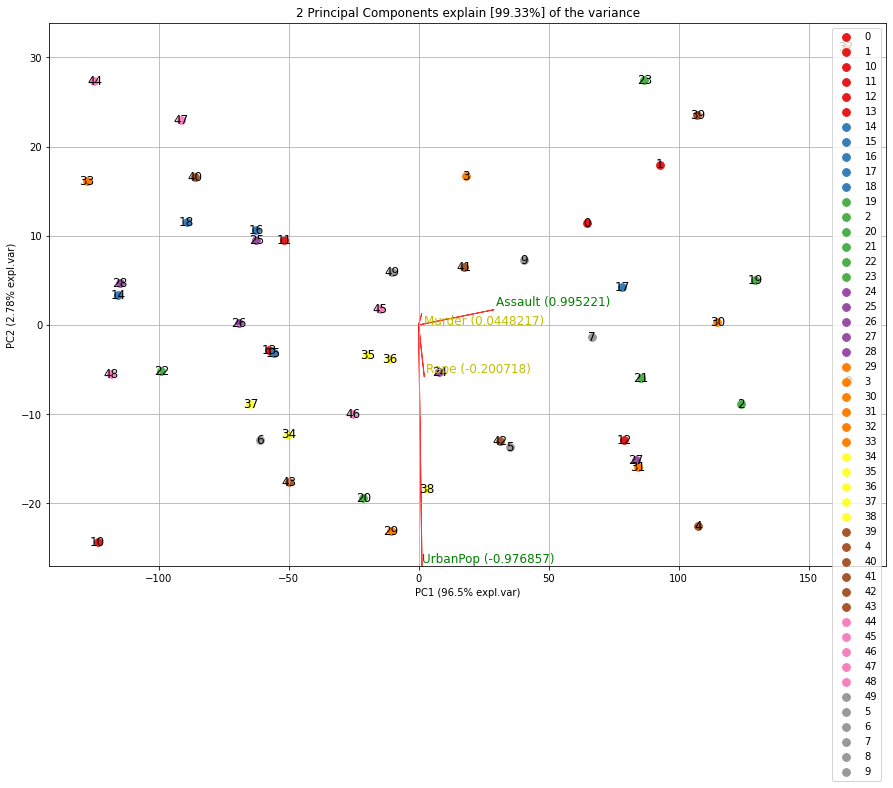

In [16]:
model = pca_lib(n_components=2)

results = model.fit_transform(arrest_df.iloc[:, 1:5])

# Make biplot with total number of features

fig, ax = model.biplot(n_feat = 4, )

Each point on a biplot is the projected observation, transformed from the original data. The importance of each feature is indicated by the length of the arrows on the biplot. This corresponds to the magnitude of the values in the eigenvectors. 

From this biplot, we see that UrbanPop appears to be the most important feature in PC2 as the arrow to this dominates the biplot downwards. This could be bias data though due to this being a percentage value as opposed to the other variables being counts.

Assault appears to be the most important feature in PC2. 

This information can also be quantified as follows:

##Feature importance:

In [17]:
print(model.results['topfeat'])

    PC   feature   loading  type
0  PC1   Assault  0.995221  best
1  PC2  UrbanPop -0.976857  best
2  PC2    Murder  0.044822  weak
3  PC2      Rape -0.200718  weak


In [18]:
labels =arrest_df.columns[1:]

pc1 = abs( pca.components_[0] )
pc2 = abs( pca.components_[1] )

feat_df = pd.DataFrame()
feat_df["Features"] = list(labels)
feat_df["PC1 Importance"] = pc1
feat_df["PC2 Importance"] = pc2
feat_df

,Features,PC1 Importance,PC2 Importance
0,Murder,0.041704,0.044822
1,Assault,0.995221,0.058760
2,UrbanPop,0.046336,0.976857
3,Rape,0.075156,0.200718


From both the above feature importances, we can see that this matches the biplot as Assault is the most important feature in PC1 and UrbanPop is the most important in PC2.

#Data Scaling:

###Standardise the data to ensure some features do not get swamped by others:

In [19]:
# select independent variable and standardise features

scaled = StandardScaler().fit_transform(arrest_df.iloc[:,1:5])

# create scaled version of DataFrame

arrest_df_scaled = pd.DataFrame(scaled, columns = arrest_df.columns[1:5])
arrest_df_scaled.head()

,Murder,Assault,UrbanPop,Rape
0,1.255179,0.790787,-0.526195,-0.003451
1,0.513019,1.118060,-1.224067,2.509424
2,0.072361,1.493817,1.009122,1.053466
3,0.234708,0.233212,-1.084492,-0.186794
4,0.281093,1.275635,1.776781,2.088814


##Component attribution to explained variance: 

In [20]:
# Fit PCA

pca = PCA().fit(arrest_df_scaled)

In [21]:
# show how each component attributes itself to the explained variance

pca.explained_variance_ratio_

array([0.62006039, 0.24744129, 0.0891408 , 0.04335752])

##Minimum components needed for analysis:

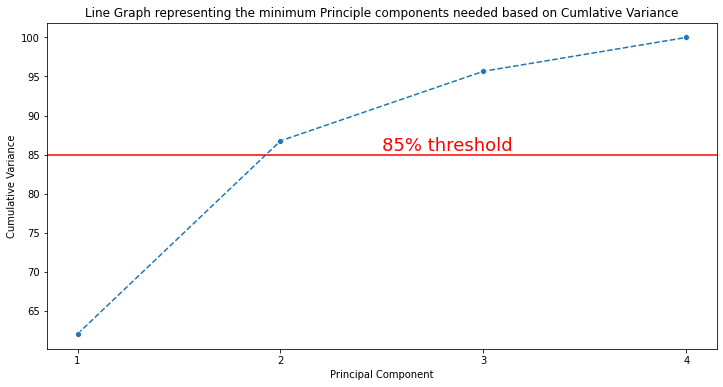

In [22]:
X = np.arange(1, 5, step=1)

plt.figure(figsize=(12,6))
sns.lineplot(x=X, y = np.cumsum(pca.explained_variance_ratio_)*100, linestyle='--', marker='o')

plt.title('Line Graph representing the minimum Principle components needed based on Cumlative Variance')
plt.xlabel('Principal Component')
plt.xticks(np.arange(1, 5, step=1))
plt.ylabel('Cumulative Variance')
plt.axhline(y=85, color = 'r', linestyle='-')
plt.text(2.5, 85.5, '85% threshold', color='red', fontsize=18)
plt.show()

From the above graph, we can see that it will be the most reasonable course of action to work with 2 components as this is the minmum amount of components that reach over our set 85% threshold.

##Scree Plot:

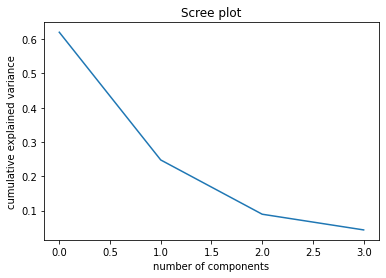

In [23]:
# Scree plot

plt.plot(pca.explained_variance_ratio_)
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.title("Scree plot")
plt.show()

The scree plot also shows that the first 2 principal components together explain most of the variance and therefore we are right to use these to perform cluster analysis. 

##Fit and transform with 2 components:

In [24]:
#PCA with 2 components
pca = PCA(n_components=2)

PC = pca.fit_transform(arrest_df_scaled)

PC.shape

(50, 2)

##Transform into DataFrame:

In [25]:
PC_df = pd.DataFrame(data = PC, columns = ['Principal Component 1', 'Principal Component 2'])

PC_df['State'] = arrest_df['State']

PC_df.head()

,Principal Component 1,Principal Component 2,State
0,0.985566,1.133392,Alabama
1,1.950138,1.073213,Alaska
2,1.763164,-0.745957,Arizona
3,-0.141420,1.119797,Arkansas
4,2.523980,-1.542934,California


##Barplot to show the relationship between each Component and the variance:

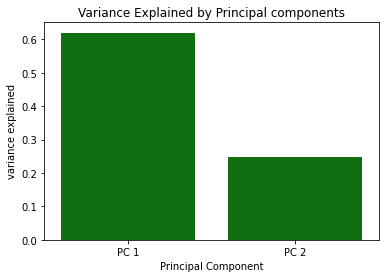

In [26]:
arrest_df_variance = pd.DataFrame({'variance explained' : pca.explained_variance_ratio_, 
                          'Principal Component' : ['PC 1', 'PC 2']})

plt.title('Variance Explained by Principal components')
sns.barplot(x='Principal Component', y='variance explained', data=arrest_df_variance, 
            color='g')
plt.show()

The barplot shows that the majority of the variance in the dataset can be attribute to PC1.

##Biplot to represent Components within the scaled DataFrame:

[pca] >Column labels are auto-completed.
[pca] >Row labels are auto-completed.
[pca] >The PCA reduction is performed on the [4] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Outlier detection using Hotelling T2 test with alpha=[0.05] and n_components=[2]
[pca] >Outlier detection using SPE/DmodX with n_std=[2]
[pca] >Plot PC1 vs PC2 with loadings.


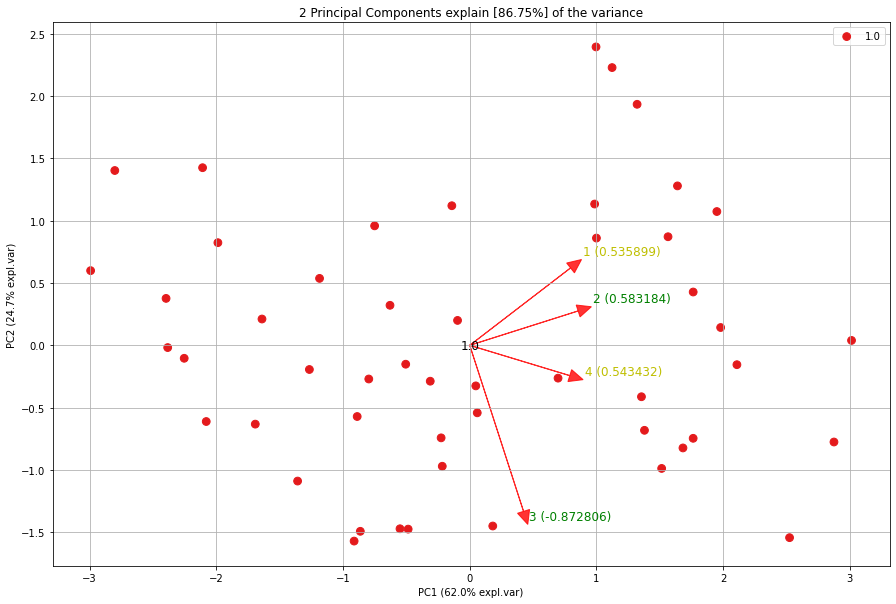

In [27]:
model = pca_lib(n_components=2)

results = model.fit_transform(scaled)

# Make biplot with total number of features

fig, ax = model.biplot(n_feat = 4, )

We see that the standardised data results in more of the variables being utilised to explain the variance, as UrbanPop no longer dominates it.

##Feature importance (scaled data):

In [28]:
print(model.results['topfeat'])

    PC feature   loading  type
0  PC1       2  0.583184  best
1  PC2       3 -0.872806  best
2  PC1       1  0.535899  weak
3  PC1       4  0.543432  weak


In [29]:
labels =arrest_df.columns[1:]

pc1 = abs( pca.components_[0] )
pc2 = abs( pca.components_[1] )

feat_df = pd.DataFrame()
feat_df["Features"] = list(labels)
feat_df["PC1 Importance"] = pc1
feat_df["PC2 Importance"] = pc2
feat_df

,Features,PC1 Importance,PC2 Importance
0,Murder,0.535899,0.418181
1,Assault,0.583184,0.187986
2,UrbanPop,0.278191,0.872806
3,Rape,0.543432,0.167319


We can see that now most of the variables contribute fairly evenly, especially in PC1.

#Cluster Analysis

##Hierarchical Clustering:

###Transform the data:

In [30]:
X_std_trans = pca.transform(arrest_df_scaled)
pca_df = pd.DataFrame(X_std_trans[:,0:5], index = arrest_df['State'])
pca_df.head()

,0,1
State,,
Alabama,0.985566,1.133392
Alaska,1.950138,1.073213
Arizona,1.763164,-0.745957
Arkansas,-0.141420,1.119797
California,2.523980,-1.542934


###Plot the dendrograms for each of the methods: single, average and complete:

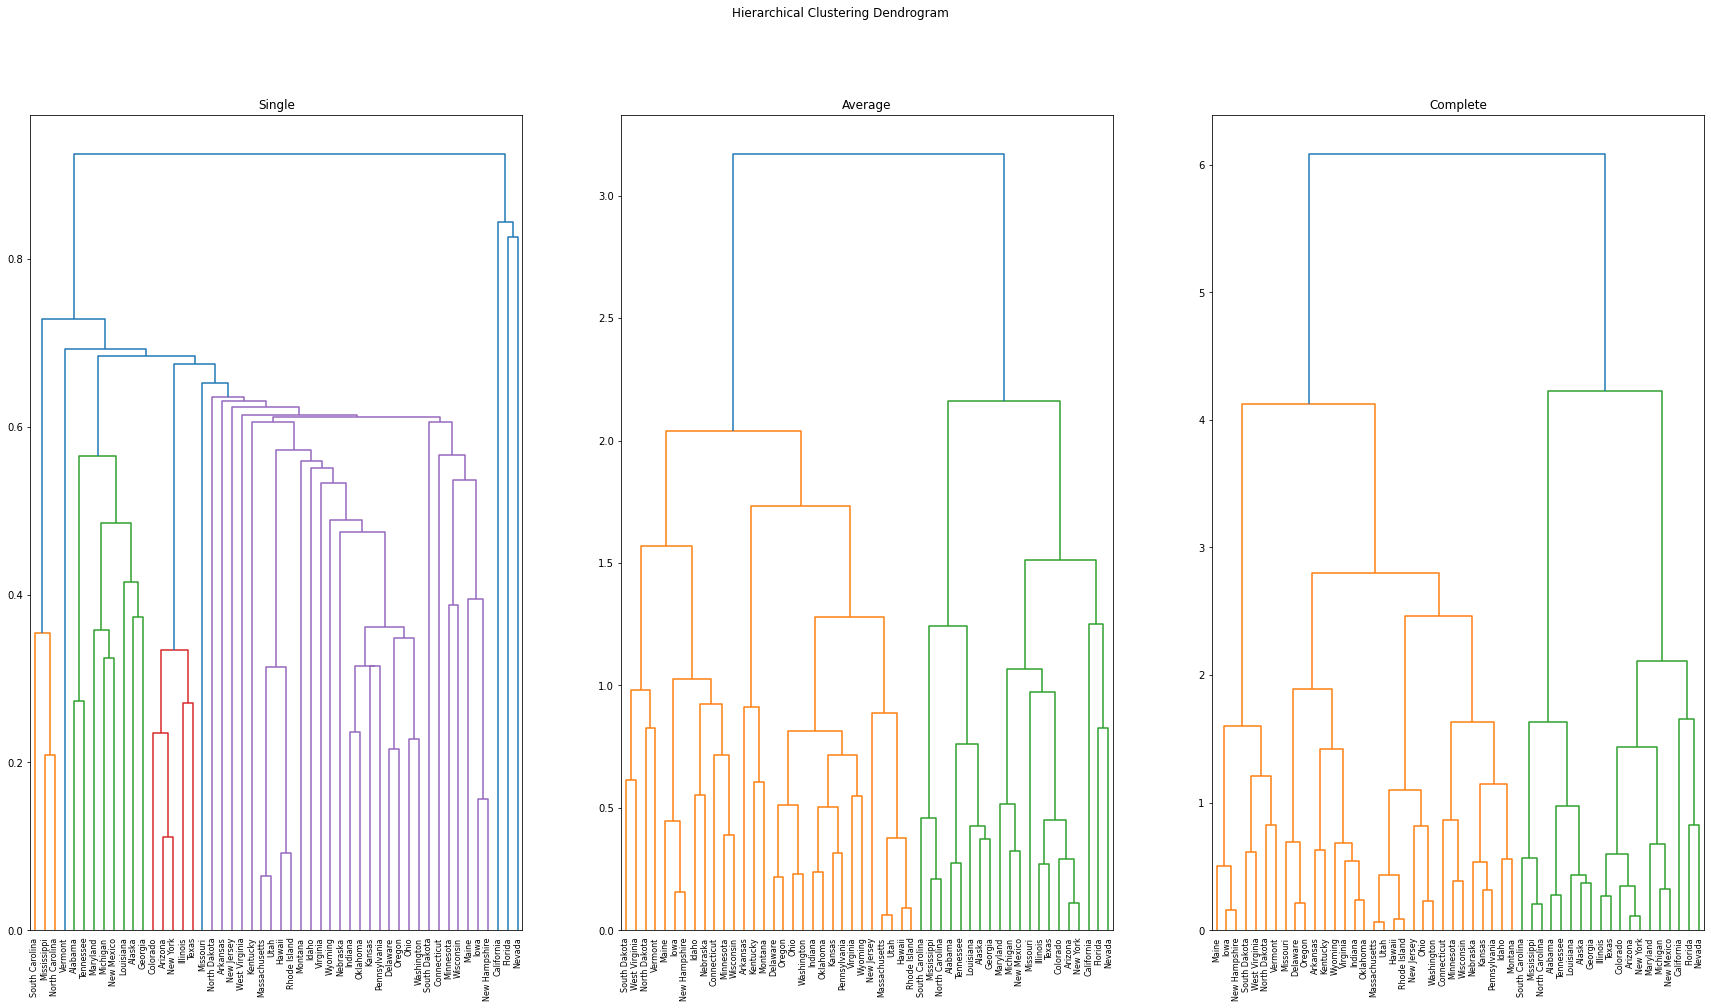

In [38]:
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)
model = model.fit(pca_df)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30, 15))
fig.suptitle('Hierarchical Clustering Dendrogram')


# Use multiple methods: single, average, complete
ax1.set_title("Single")
dendrogram(linkage(pca_df, method='single'), labels=pca_df.index, ax=ax1) 
ax2.set_title("Average")
dendrogram(linkage(pca_df, method='average'), labels=pca_df.index, ax=ax2)
ax3.set_title("Complete")
dendrogram(linkage(pca_df, method='complete'), labels=pca_df.index, ax=ax3)
plt.show()

From the above hierarchical clusters, we can see that the Average linkage and Complete linkage have a very similar show of clusters with the optimum being 4. 

###Plot the complete linkage dendrogram on its own to compare with K-means:

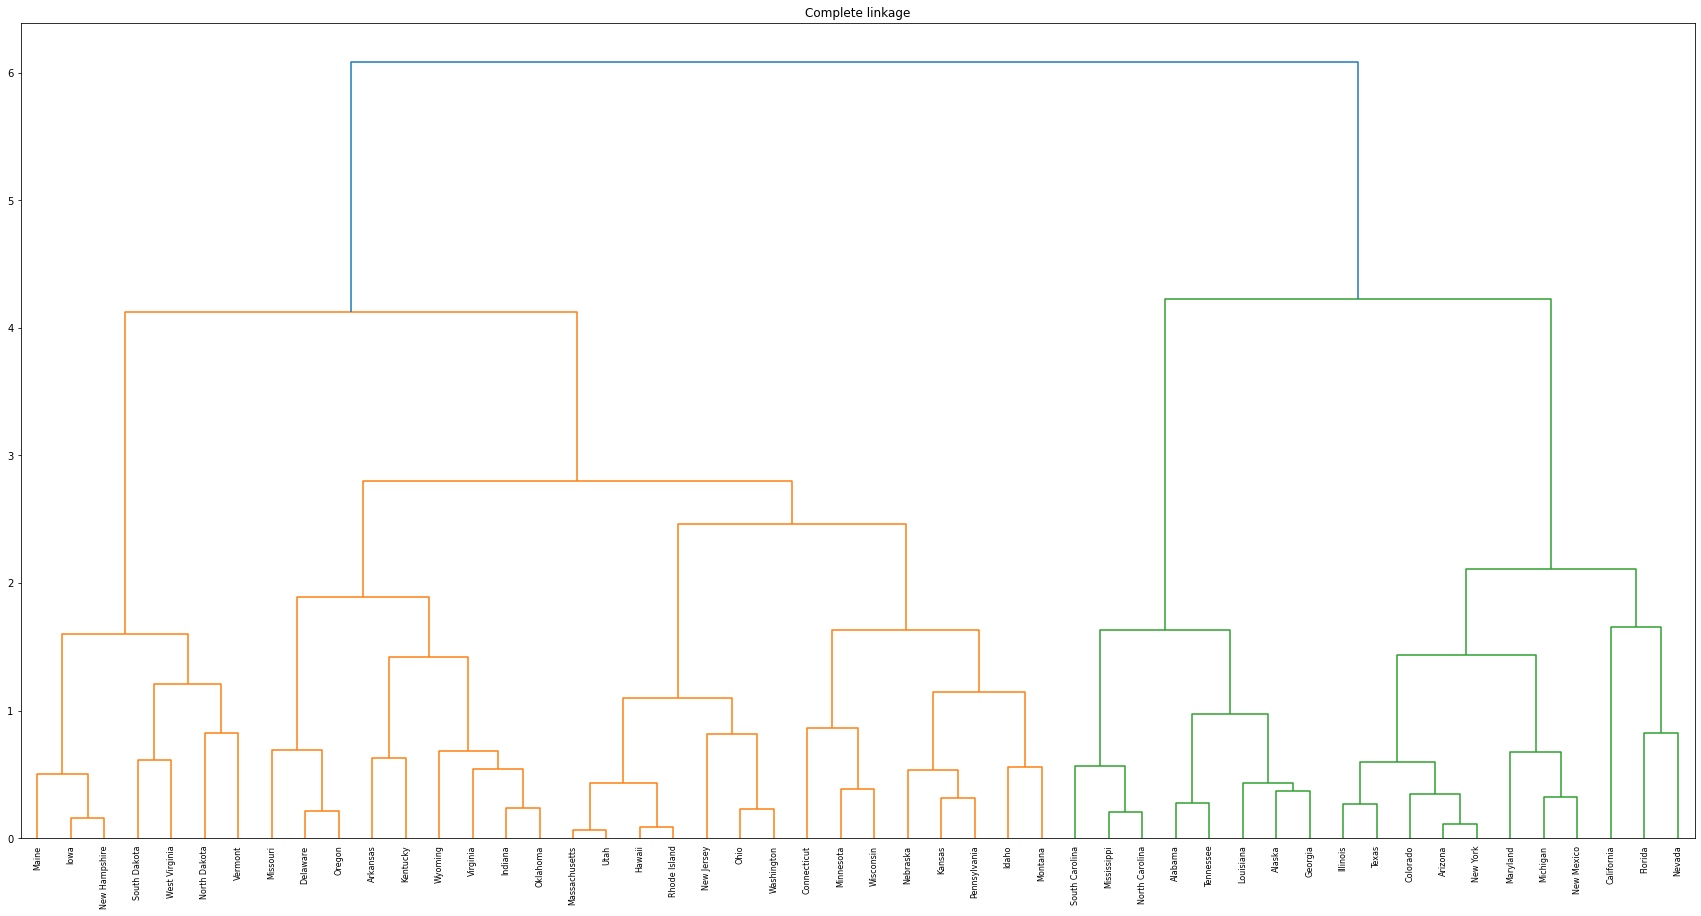

In [41]:
plt.figure(figsize=(30, 15))
plt.title("Complete linkage")
dendrogram(linkage(pca_df, method='complete'), labels=pca_df.index)
plt.show()

##K-means:

###Fit and plot K-means: 

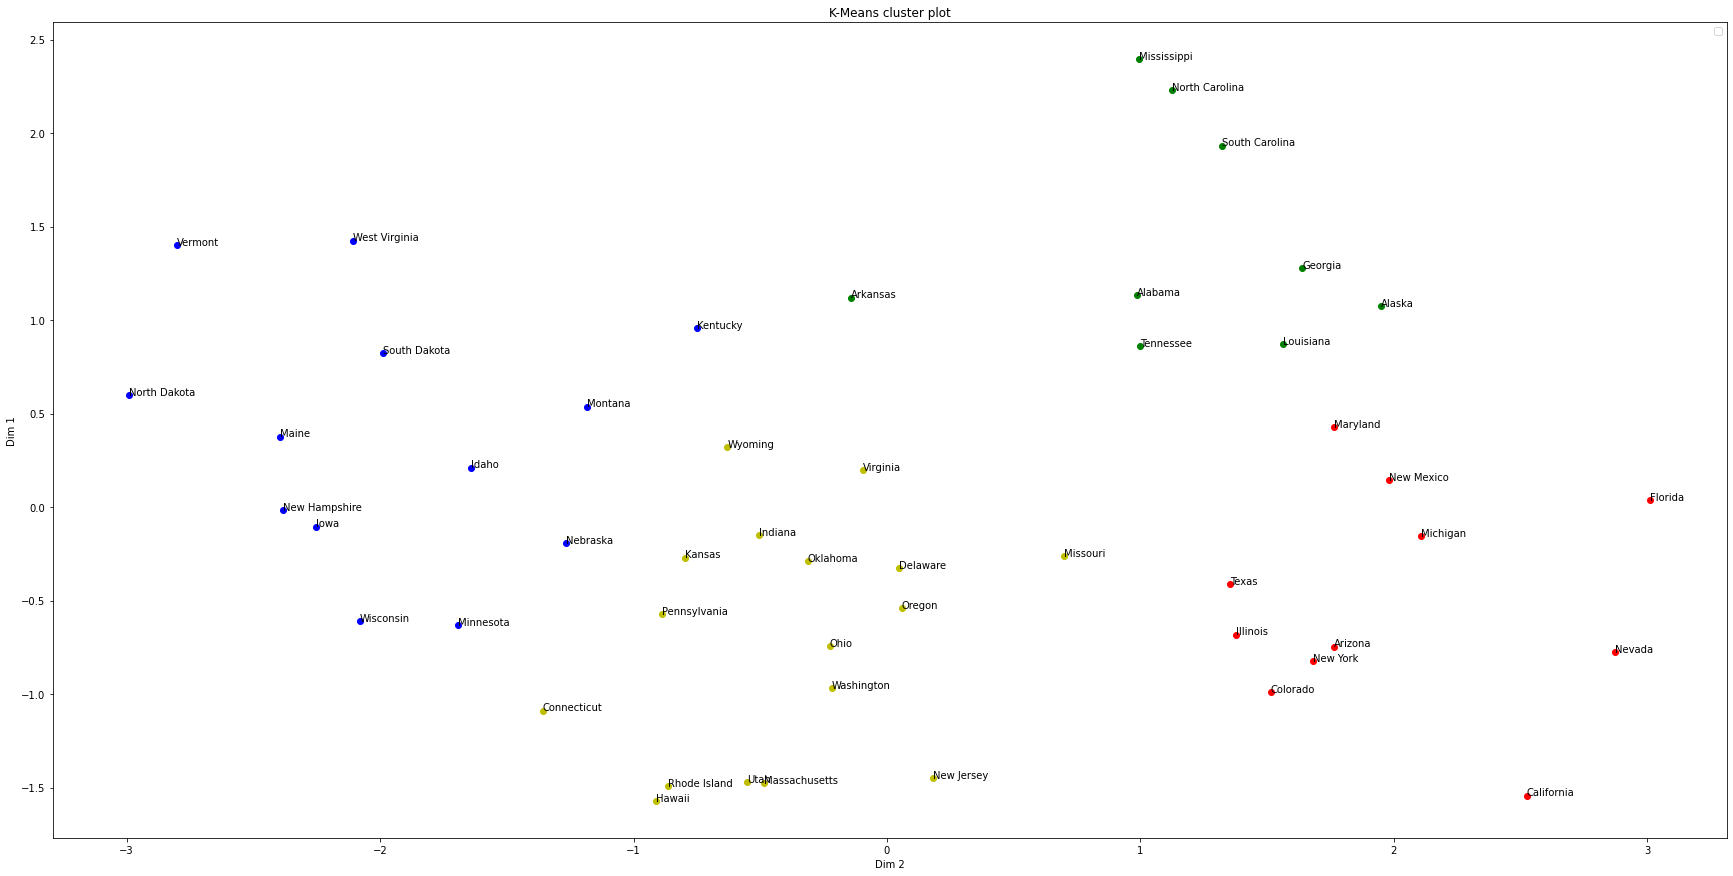

In [46]:
# Extract the first two components
x = X_std_trans[:,0]
y = X_std_trans[:,1]

# Fit k-means
k=4
kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42)
cluster_labels = kmeans.fit_predict(pca_df)
cent = kmeans.cluster_centers_

# Plot clusters
fig, ax = plt.subplots(figsize=(30, 15))
colours = 'rbgy'
for i in range(0,k):
    ax.scatter(x[cluster_labels == i],y[cluster_labels == i],c = colours[i]) 

for i in range(0,len(x)):
        txt = pca_df.index[i]
        ax.annotate(txt, (x[i], y[i]))
ax.set_title("K-Means cluster plot")
ax.set_xlabel("Dim 2")
ax.set_ylabel("Dim 1")
ax.legend()

Through comparision of the hierarchical clusters of the dendrograms to the clusters in the K-means, we can see that they have a very similar clustering. For example looking at specific leaves on the complete linkage dendrogram, we can see that Maine, New Hampshire and Iowa are all close together and joined into the same cluster. If we then compare this to the K-means, we can see that these 3 states are also close together in the blue cluster. 

Further to this, Colorado, New York and Arizona are close together and further to the right in both the complete linkage dendrogram and K-means clusters.

This continues when looking at each of the states in the dendrograms and K-means which shows they are very similar in comparison.